# Keras Tuner: CIFAR10 Classfication

In the previous notebook, we manually tuned the hyper parameters to improve the test accuracy. We are now going to make use of Keras Tuner library to perform hypertuning.

Best Validation Accuracy with manually tuning: 67.4%
We are going to use that as our baseline.

Can we beat that?


@date: 17-Aug-2020 | @author: katnoria

In [59]:
import pickle
from time import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model
import IPython
import kerastuner as kt

In [2]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [3]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [5]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [6]:

IMG_SIZE = 32
NUM_CLASSES = metadata.features["label"].num_classes
print(f"Classes: {NUM_CLASSES}")

Classes: 10


In [7]:
IMG_SIZE = 32
# test
train_ds = ds_train \
    .cache() \
    .batch(1, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

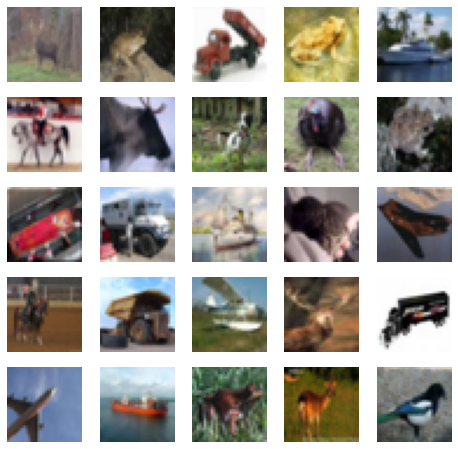

In [8]:
examples = ds_train.take(64)

fig, axs = plt.subplots(5, 5, figsize=(8,8))

for record, ax in zip(examples, axs.flat):
    image, _ = record
    ax.imshow(image)
    ax.axis('off')
plt.show()    

In [9]:
# we no longer need it
del train_ds

In [10]:
# Base Model
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

# Data Augmentation

In [48]:
# def transforms(x, hp):
#     use_rotation = hp.Boolean('use_rotation')
#     if use_rotation:
#         x = tf.keras.layers.experimental.preprocessing.RandomRotation(
#             hp.Float('rotation_factor', min_value=0.05, max_value=0.2)
#         )(x)

#     use_flip = hp.Boolean('use_flip')
#     if use_flip:
#         tf.keras.layers.experimental.preprocessing.RandomFlip(
#           hp.Choice('orientation', values=['vertical', 'horizontal', 'horizontal_and_vertical'])
#         )(x)

#     #   use_zoom = hp.Boolean('use_zoom')
#     #   if use_zoom:
#     #     x = tf.keras.layers.experimental.preprocessing.RandomZoom(
#     #         hp.Float('use_zoom', min_value=0.05, max_value=0.2)
#     #     )(x)

#     return x

# Without making any changes to image augmentation
transforms = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [43]:
  # Load dataset
(ds_train, ds_test), metadata = tfds.load(
  'cifar10', split=['train', 'test'], shuffle_files=True, 
  with_info=True, as_supervised=True
  )

In [44]:
num_train_examples=len(ds_train)

In [45]:
# create train and test batch
BS = 128
train_ds = ds_train \
  .cache() \
  .shuffle(num_train_examples).batch(BS, drop_remainder=True) \
  .prefetch(tf.data.experimental.AUTOTUNE) 
  
test_ds = ds_test \
    .cache() \
    .batch(BS, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE)       


In [61]:
from kerastuner import HyperModel

class BasicResnet50Model(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes
    
    def build(self, hp):
        inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = transforms(inputs)
        x = tf.keras.applications.resnet.preprocess_input(x)
        x = base_model(x, training=False)
        x = Flatten()(x)          
        
        use_dense = hp.Boolean('use_dense')
        if use_dense:
            hp_activation = hp.Choice('activation', values=['relu', 'selu', 'elu'])  
            hp_drop_rate = hp.Float('rate', min_value=0.1, max_value=0.8, step=0.1)              
            num_dense_units = hp.Int('units', min_value=32, max_value=1024, step=32)
            x = Dense(num_dense_units)(x)
            x = Dropout(hp_drop_rate)(x)        
        outputs = Dense(NUM_CLASSES)(x)    
        model = tf.keras.Model(inputs, outputs)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(
          optimizer=tf.keras.optimizers.Adam(hp_learning_rate),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy']
          )

        return model
    
basic_resnet_model = BasicResnet50Model(10)

In [62]:
# def model_builder(hp):
#     inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))    
# #     x = transforms(inputs, hp)
#     x = transforms(inputs)
#     x = tf.keras.applications.resnet.preprocess_input(x)
#     x = base_model(x, training=False)
#     hp_num_filters = hp.Int('filters', min_value=32, max_value=512, step=32)
#     hp_activation = hp.Choice('activation', val1ues=['relu', 'selu', 'elu'])  
#     x = Conv2D(hp_num_filters, 2, padding='same', input_shape=(1,1,2048), activation=hp_activation)(x)
#     hp_drop_rate = hp.Float('rate', min_value=0.1, max_value=0.8, step=0.1)  
#     x = Dropout(hp_drop_rate)(x)
#     x = GlobalAveragePooling2D()(x)  
#     x = Dropout(hp_drop_rate)(x)
#     use_dense = hp.Boolean('use_dense')
#     if use_dense:
#         num_dense_units = hp.Int('units', min_value=32, max_value=1024, step=32)
#         x = Dense(num_dense_units)(x)
#         x = Dropout(hp_drop_rate)(x)        
#     outputs = Dense(NUM_CLASSES)(x)    
#     model = tf.keras.Model(inputs, outputs)

#     hp_learning_rate = hp.Float('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(
#       optimizer=tf.keras.optimizers.Adam(hp_learning_rate),
#       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#       metrics=['accuracy']
#       )

#     return model

In [63]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

# Hyperband

In [64]:
tuner = kt.Hyperband(
    basic_resnet_model, objective='val_accuracy',  
    max_epochs = 50, factor = 3, project_name = 'cifar10-dense'
    )

INFO:tensorflow:Reloading Oracle from existing project ./cifar10-dense/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./cifar10-dense/oracle.json


In [ ]:
start = time()
tuner.search(
    train_ds, epochs = 100, validation_data = test_ds, 
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=3), ClearTrainingOutput()]
    )
end = time()

Epoch 1/50
109/390 [=======>......................] - ETA: 0s - loss: 9.9182 - accuracy: 0.09 - ETA: 4s - loss: 8.8156 - accuracy: 0.10 - ETA: 4s - loss: 8.5937 - accuracy: 0.09 - ETA: 4s - loss: 8.1533 - accuracy: 0.10 - ETA: 4s - loss: 7.6509 - accuracy: 0.10 - ETA: 4s - loss: 7.3136 - accuracy: 0.11 - ETA: 4s - loss: 7.0269 - accuracy: 0.12 - ETA: 4s - loss: 6.7683 - accuracy: 0.12 - ETA: 4s - loss: 6.5282 - accuracy: 0.12 - ETA: 4s - loss: 6.3670 - accuracy: 0.12 - ETA: 4s - loss: 6.1838 - accuracy: 0.12 - ETA: 4s - loss: 6.0317 - accuracy: 0.13 - ETA: 4s - loss: 5.9007 - accuracy: 0.13 - ETA: 4s - loss: 5.7623 - accuracy: 0.13 - ETA: 4s - loss: 5.6425 - accuracy: 0.14 - ETA: 4s - loss: 5.5402 - accuracy: 0.14 - ETA: 4s - loss: 5.4358 - accuracy: 0.14 - ETA: 4s - loss: 5.3473 - accuracy: 0.14 - ETA: 4s - loss: 5.2744 - accuracy: 0.15 - ETA: 4s - loss: 5.1943 - accuracy: 0.15 - ETA: 4s - loss: 5.1169 - accuracy: 0.15 - ETA: 4s - loss: 5.0448 - accuracy: 0.15 - ETA: 3s - loss: 4.9686

In [75]:
took = end - start
print(f"Total training time: {took//60 : .0f}m {took%60:.0f}s")

Total training time:  70m 17s


In [72]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

{'use_dense': True,
 'learning_rate': 0.0001,
 'activation': 'elu',
 'rate': 0.6,
 'units': 544,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '13b99c5ebe573d99654f9c27118f8dd1'}

### Checkpointing

We do not need to manually save the best model or hyper param. Keras-Tuner records every trial and you can just load it back using the same command used above.

Test: Restart the notebook, do not run the trial and execute the cells below

In [69]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [70]:
best_hyperparameters.values

{'use_dense': True,
 'learning_rate': 0.0001,
 'activation': 'elu',
 'rate': 0.6,
 'units': 544,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '13b99c5ebe573d99654f9c27118f8dd1'}

### Evaluate

Let's evaluate the best model against the test set

In [73]:
best_model.evaluate(test_ds)

78/78 [==============================] - ETA: 0s - loss: 1.1740 - accuracy: 0.61 - ETA: 0s - loss: 1.0788 - accuracy: 0.62 - ETA: 0s - loss: 1.1089 - accuracy: 0.61 - ETA: 0s - loss: 1.1142 - accuracy: 0.61 - ETA: 0s - loss: 1.1214 - accuracy: 0.61 - ETA: 0s - loss: 1.1479 - accuracy: 0.59 - ETA: 0s - loss: 1.1393 - accuracy: 0.60 - ETA: 0s - loss: 1.1488 - accuracy: 0.60 - ETA: 0s - loss: 1.1498 - accuracy: 0.59 - ETA: 0s - loss: 1.1499 - accuracy: 0.59 - ETA: 0s - loss: 1.1511 - accuracy: 0.59 - ETA: 0s - loss: 1.1507 - accuracy: 0.59 - ETA: 0s - loss: 1.1555 - accuracy: 0.59 - ETA: 0s - loss: 1.1579 - accuracy: 0.59 - ETA: 0s - loss: 1.1571 - accuracy: 0.59 - ETA: 0s - loss: 1.1560 - accuracy: 0.59 - ETA: 0s - loss: 1.1563 - accuracy: 0.59 - 1s 12ms/step - loss: 1.1588 - accuracy: 0.5953


[1.1587920188903809, 0.5952523946762085]

**Alright, we have improved the test accuracy from the baseline of 64.7 to 69.4%**

# Tuner: Random Search

Next, we also give random search a shot. There are other tuners available. You can find the complete list [here](https://keras-team.github.io/keras-tuner/documentation/tuners/)

In [ ]:
tuner = kt.tuners.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=100,
    overwrite=True,
    project_name = 'cifar10-kt-randomsearch'
)

callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, baseline=0.9),
             ClearTrainingOutput()
             ]


tuner.search(train_ds, epochs=100, callbacks=callbacks, validation_data=train_ds)

Epoch 1/100
390/390 [==============================] - ETA: 0s - loss: 17.6757 - accuracy: 0.125 - ETA: 4s - loss: 17.4041 - accuracy: 0.113 - ETA: 5s - loss: 17.0686 - accuracy: 0.102 - ETA: 5s - loss: 15.9421 - accuracy: 0.108 - ETA: 5s - loss: 15.1509 - accuracy: 0.113 - ETA: 6s - loss: 14.4365 - accuracy: 0.120 - ETA: 6s - loss: 14.0322 - accuracy: 0.120 - ETA: 6s - loss: 13.5348 - accuracy: 0.127 - ETA: 5s - loss: 13.0370 - accuracy: 0.128 - ETA: 5s - loss: 12.7324 - accuracy: 0.130 - ETA: 5s - loss: 12.4394 - accuracy: 0.134 - ETA: 5s - loss: 12.1868 - accuracy: 0.135 - ETA: 5s - loss: 12.0454 - accuracy: 0.137 - ETA: 5s - loss: 11.8099 - accuracy: 0.141 - ETA: 5s - loss: 11.6459 - accuracy: 0.143 - ETA: 5s - loss: 11.4855 - accuracy: 0.146 - ETA: 5s - loss: 11.3995 - accuracy: 0.147 - ETA: 5s - loss: 11.2716 - accuracy: 0.148 - ETA: 5s - loss: 11.1312 - accuracy: 0.151 - ETA: 5s - loss: 11.0037 - accuracy: 0.153 - ETA: 5s - loss: 10.8857 - accuracy: 0.155 - ETA: 4s - loss: 10.80

In [39]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

{'use_rotation': False,
 'use_zoom': False,
 'filters': 480,
 'activation': 'relu',
 'rate': 0.1,
 'use_dense': True,
 'learning_rate': 0.0001,
 'rotation_factor': 0.13130608219161216,
 'units': 96}

In [40]:
best_model = tuner.get_best_models(1)[0]
best_model.evaluate(test_ds)

78/78 [==============================] - ETA: 0s - loss: 0.9007 - accuracy: 0.66 - ETA: 0s - loss: 0.8636 - accuracy: 0.67 - ETA: 0s - loss: 0.8956 - accuracy: 0.66 - ETA: 0s - loss: 0.8850 - accuracy: 0.67 - ETA: 0s - loss: 0.8969 - accuracy: 0.67 - ETA: 0s - loss: 0.9076 - accuracy: 0.67 - ETA: 0s - loss: 0.9072 - accuracy: 0.68 - ETA: 0s - loss: 0.9082 - accuracy: 0.67 - ETA: 0s - loss: 0.9178 - accuracy: 0.67 - ETA: 0s - loss: 0.9221 - accuracy: 0.67 - ETA: 0s - loss: 0.9305 - accuracy: 0.67 - ETA: 0s - loss: 0.9337 - accuracy: 0.67 - ETA: 0s - loss: 0.9306 - accuracy: 0.67 - ETA: 0s - loss: 0.9414 - accuracy: 0.66 - ETA: 0s - loss: 0.9417 - accuracy: 0.66 - ETA: 0s - loss: 0.9376 - accuracy: 0.66 - ETA: 0s - loss: 0.9413 - accuracy: 0.66 - ETA: 0s - loss: 0.9430 - accuracy: 0.66 - 1s 13ms/step - loss: 0.9412 - accuracy: 0.6683


[0.941247820854187, 0.6682692170143127]

# Keras Code 
Code from https://github.com/keras-team/keras-tuner/blob/master/examples/cifar10.py

In [ ]:
import kerastuner as kt
import tensorflow as tf
import tensorflow_datasets as tfds


def build_model(hp):
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = inputs
    for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
        filters = hp.Int('filters_' + str(i), 32, 256, step=32)
        for _ in range(2):
            x = tf.keras.layers.Convolution2D(
              filters, kernel_size=(3, 3), padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
        if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
            x = tf.keras.layers.MaxPool2D()(x)
        else:
            x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
    x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])
    return model


tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    directory="/content/gdrive/My Drive/mldrive/models/cifar10-kt",
    project_name='cf10-fullsearch'
    )

data = tfds.load('cifar10')
train_ds, test_ds = data['train'], data['test']


def standardize_record(record):
    return tf.cast(record['image'], tf.float32) / 255., record['label']


train_ds = train_ds.map(standardize_record).cache().batch(64).shuffle(10000)
test_ds = test_ds.map(standardize_record).cache().batch(64)

tuner.search(train_ds,
             validation_data=test_ds,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1), ClearTrainingOutput()],
             )

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [ ]:
best_hyperparameters.values

{'conv_blocks': 5,
 'dropout': 0.0,
 'filters_0': 128,
 'filters_1': 160,
 'filters_2': 160,
 'filters_3': 192,
 'filters_4': 224,
 'hidden_size': 80,
 'learning_rate': 0.0025359172395390105,
 'pooling_0': 'max',
 'pooling_1': 'max',
 'pooling_2': 'max',
 'pooling_3': 'max',
 'pooling_4': 'max',
 'tuner/bracket': 2,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/round': 2,
 'tuner/trial_id': 'b780a5e9191d55c360ad5be6040decc4'}

In [ ]:
best_model.evaluate(test_ds)

157/157 [==============================] - 1s 7ms/step - loss: 0.5936 - accuracy: 0.8021


[0.5936421751976013, 0.8021000027656555]

In [ ]:
path = "/content/gdrive/My Drive/mldrive/models/cifar10-kt"

import pickle
pickle.dump(best_hyperparameters.values, open(f"{path}/transfer_learning_params.pkl", "wb"))

In [ ]:
best_model.save_weights("/content/gdrive/My Drive/mldrive/models/cifar10-kt/best_model")

In [ ]:
!ls

gdrive	sample_data  untitled_project
